Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# EEAGER model demonstration notebook

This notebook is a demonstration of the end-to-end workflow described in the paper EEAGER: A neural network model for finding beaver complexes in satellite and aerial imagery (*in review*).  This notebook is for reproducability of the model described in the paper and any data or models used are purely for demonstration purposes.  The workflow requires access to training data (latitude and longitude coordinates and a date) and high-resolution imagery, high enough resolution to see beaver habitat.

NOTICE: This is an experimental project and is not an officially supported Google project. You are welcome to use it, but we do not guarantee stability.

## Imports

In [ ]:
import ee
import google
from google.colab import auth
from pprint import pprint

## Authentication and initialization

In [ ]:
auth.authenticate_user()
credentials, project_id = google.auth.default()
ee.Initialize(credentials, project='your-google-cloud-project')

In [ ]:
#@title Pseudo-absence library functions


def around_a_region(region: ee.FeatureCollection, num_points: int,
                    donut_outer_radius: int, donut_inner_radius: int,
                    valley_only: bool) -> ee.FeatureCollection:
  """Returns pseudo-absence points around a given region.

  Args:
    region: an ee.FeatureCollection describing the region around which
      pseudo-absence points need to be found.
    num_points: the number of desired pseudo-absence points. Must be a positive
      integer.
    donut_outer_radius: outer radius of the donut around the 'region' from which
      pseudo-absence points are sampled (in meter). Must be a positive integer.
    donut_inner_radius: inner radius of the donut around the 'region' from which
      pseudo-absence points are sampled (in meter). Must be a positive integer
      and less than 'donut_outer_radius'.
    valley_only: if true, only points from valleys are selected as
      pseudo-absence points.

  Returns:
     an ee.FeatureCollection containing random points around
    'presence_data' with 'beaver' property set to 0 in each feature.
  """

  def _set_datetime_and_beaver_properties(feature: ee.Feature) -> ee.Feature:
    datetime = ee.Date(ee.Feature(
        feature.get('presence')).get('date'))
    return ee.Feature(feature.geometry(), {'date': datetime, 'beaver': 0})

  if num_points <= 0:
    raise ValueError(f'num_points must be a positive integer, not {num_points}')
  if donut_outer_radius <= 0:
    raise ValueError(
        f'donut_outer_radius must be a positive integer, not {donut_outer_radius}'
    )
  if donut_outer_radius <= donut_inner_radius:
    raise ValueError(
        f'donut_outer_radius {donut_outer_radius} must be greater than donut_inner_radius {donut_inner_radius} '
    )
  proximity_image: ee.Image = region.distance(donut_outer_radius).lt(
      donut_inner_radius)
  assumed_absences: ee.Image = proximity_image.Not()
  if valley_only:
    # You need to be an non-commerical user to use this dataset.
    topography: ee.Image = ee.Image('CSP/ERGo/1_0/Global/ALOS_landforms')
    alos_derived_landform_class_valley: int = 41
    alos_derived_landform_class_valley_narrow: int = 42
    valley: ee.Image = topography.eq(alos_derived_landform_class_valley).Or(
        topography.eq(alos_derived_landform_class_valley_narrow))
    assumed_absences = assumed_absences.And(valley)

  # Create a sample out of 'assumed_absences'.
  sampled_absences: ee.FeatureCollection = assumed_absences.stratifiedSample(
      numPoints=0,
      region=region.geometry().convexHull(),
      scale=1,
      classValues=[1],
      classPoints=[num_points],
      geometries=True)

  # Add dates to 'sampled_absence' from the nearest point in 'region'.
  return ee.Join.saveBest(
      matchKey='presence', measureKey='distance').apply(
          primary=sampled_absences,
          secondary=region,
          condition=ee.Filter.withinDistance(
              distance=100000,
              leftField='.geo',
              rightField='.geo',
              maxError=100)).map(_set_datetime_and_beaver_properties)



## Load a table of training data


In [ ]:
def _set_date(feature: ee.Feature) -> ee.Feature:
  """Returns a given feature by converting its date property from a string to an ee.Date object.

  Args:
    feature: feature whose date property needs to be updated.
  Returns: the updated feature.
  """
  return feature.set('date', ee.Date.parse('MM/dd/yyyy', feature.get('date')))

def convert_date_and_add_beaver_property(feature: ee.Feature) -> ee.Feature:
    return feature.set({'date': ee.Date(feature.get('date')), 'beaver': 1})

# Fake data.  REPLACE WITH YOUR DATASET.
fake_points =  [
  [-122.48690768498312,
    38.60714566563211],
  [-122.48180075901877,
    38.603674618029544],
  [-122.44300528782736,
    38.644239331968244],
  [-122.4820582510842,
    38.66196844440349],
  [-122.48100682515036,
    38.639795881658046],
  [-122.46888324040304,
    38.63538778515559],
  [-122.47506304997336,
    38.64360037054772],
  [-122.435042080876,
    38.627084824833716],
  [-122.47559171676312,
    38.66260346316601],
  [-122.47250181197796,
    38.66208405712206],
  [-122.46909004211102,
    38.66057608274635],
  [-122.49013313955903,
    38.648786031690506],
  [-122.4492016305976,
    38.62550994402961],
  [-122.43978707695533,
    38.6186574755073]
]

presence_points = ee.FeatureCollection([
    ee.Feature(
        ee.Geometry.Point(coord), {'date': '07/03/2014'})
        for coord in fake_points]
        ).map(_set_date)

NUM_POINTS = len(fake_points) * 4
# Notice: Different from paper values for this toy example.
# The next two are in meters.
DONUT_OUTER_RADIUS = 1000
DONUT_INNER_RADIUS = 100
VALLEY_ONLY = False

presence_points = presence_points.map(convert_date_and_add_beaver_property)
pseudo_absence_points: ee.FeatureCollection = around_a_region(
    presence_points, NUM_POINTS, DONUT_OUTER_RADIUS,
    DONUT_INNER_RADIUS, VALLEY_ONLY)

pprint(pseudo_absence_points.getInfo())

{'columns': {},
 'features': [{'geometry': {'coordinates': [-122.46166778930078,
                                            38.631397514979014],
                            'geodesic': False,
                            'type': 'Point'},
               'id': '0',
               'properties': {'beaver': 0,
                              'date': {'type': 'Date', 'value': 1404345600000}},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.46590783744182,
                                            38.654026076985986],
                            'geodesic': False,
                            'type': 'Point'},
               'id': '1',
               'properties': {'beaver': 0,
                              'date': {'type': 'Date', 'value': 1404345600000}},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.47498082181143,
                                            38.64825889286194],
                            'geodesic':

## Merge and partition

Combine presences and absences, partition to training and validation datasets.


In [ ]:
presences_and_pseudoabsences = ee.FeatureCollection(
    [presence_points, pseudo_absence_points]).flatten()

pprint(presences_and_pseudoabsences.getInfo())

{'columns': {},
 'features': [{'geometry': {'coordinates': [-122.48690768498312,
                                            38.60714566563211],
                            'type': 'Point'},
               'id': '0_0',
               'properties': {'beaver': 1,
                              'date': {'type': 'Date', 'value': 1404345600000}},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.48180075901877,
                                            38.603674618029544],
                            'type': 'Point'},
               'id': '0_1',
               'properties': {'beaver': 1,
                              'date': {'type': 'Date', 'value': 1404345600000}},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.44300528782736,
                                            38.644239331968244],
                            'type': 'Point'},
               'id': '0_2',
               'properties': {'beaver': 1,
            

In [ ]:
#@title Partitioning library functions

# Update this to a reasonable size, in meters.  See paper for details.
HEXAGON_SIZE = 2
NUM_PARTITIONS = 10

import math


def _get_hex_decomposition_image(hexagon_size: int,
                                 num_partitions: int) -> ee.Image:
  """Creates a hexagonal decomposition image.

  Args:
    hexagon_size: size of the hexagonal regions.
    num_partitions: number of partitions.

  Returns:
    an ee.Image that contains separate, hexagonal shaped regions labeled
    0, .., num_partitions - 1.
  """

  def _get_stripes(projection: ee.Projection, axis: int) -> ee.Image:
    stripes: ee.Image = ee.Image.pixelLonLat().changeProj(
        'EPSG:4326', projection).select(axis)
    return stripes.divide(hexagon_size).floor().mod(num_partitions).add(
        num_partitions).mod(num_partitions)

  projection: str = 'EPSG:3857'  # https://epsg.io/3857
  square_projection: ee.Projection = ee.Projection(
      projection, [1, 0, 0, 0, math.sqrt(3) / 2, 0])
  shear_left_projection: ee.Projection = ee.Projection(
      projection, [1, 0.5, 0, 0, math.sqrt(3) / 2, 0])
  shear_right_projection: ee.Projection = ee.Projection(
      projection, [1, -0.5, 0, 0, math.sqrt(3) / 2, 0])
  rows: ee.Image = _get_stripes(square_projection, 1)
  left: ee.Image = _get_stripes(shear_left_projection, 0)
  right: ee.Image = _get_stripes(shear_right_projection, 0)
  add: ee.Image = left.add(right)
  wheels: ee.Image = add.add(rows.multiply(num_partitions /
                                           2)).mod(num_partitions)
  rows2: ee.Image = wheels.gte(num_partitions / 2).add(rows.mod(num_partitions))
  hex_image: ee.Image = rows2.mod(num_partitions)
  return hex_image.rename('hex_mask')


def _add_partition_to_table(
    table: ee.FeatureCollection) -> ee.FeatureCollection:
  """Divides the given dataset into Geographically non-overlapping partitions.

  Args:
    table: an ee.FeatureCollection for which partition information needs to be
      added.

  Returns:
    an ee.FeatureCollection containing the partition information where a
    parition number (0, ..., number of partitions - 1) is added as hex_mask
    column to every feature of the 'table'.
  """
  hex_mask: ee.Image = _get_hex_decomposition_image(HEXAGON_SIZE,
                                                    NUM_PARTITIONS)
  return hex_mask.reduceRegions(
      collection=table,
      reducer=ee.Reducer.first().setOutputs(['hex_mask']),
      scale=10)


In [ ]:
partitioned_data_points = _add_partition_to_table(presences_and_pseudoabsences)

pprint(partitioned_data_points.getInfo())

{'columns': {'hex_mask': 'Float<0.0, 10.0>'},
 'features': [{'geometry': {'coordinates': [-122.48690768498312,
                                            38.60714566563211],
                            'type': 'Point'},
               'id': '0_0',
               'properties': {'beaver': 1,
                              'date': {'type': 'Date', 'value': 1404345600000},
                              'hex_mask': 0},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.48180075901877,
                                            38.603674618029544],
                            'type': 'Point'},
               'id': '0_1',
               'properties': {'beaver': 1,
                              'date': {'type': 'Date', 'value': 1404345600000},
                              'hex_mask': 5},
               'type': 'Feature'},
              {'geometry': {'coordinates': [-122.44300528782736,
                                            38.644239331968244],
         

## Generate training data (patches)


In [ ]:
# NB: Different from paper numbers, due to limitations in public datasets.
SCALE: float = 1.0  # In meters
KERNEL_SIZE: int = 128
PATCH_SIZE: float = KERNEL_SIZE * KERNEL_SIZE * SCALE

In [ ]:
#@title Image generation library functions


def get_scale() -> float:
  """Returns scale in meters.

  Returns: scale in meters.
  """
  return SCALE


def get_kernel_size() -> int:
  """Returns kernel size.

  Returns: kernel size.
  """
  return KERNEL_SIZE


def get_kernel(size: int):
  """Returns a square kernel of given size.

  Args:
    size: length of the kernel.
  Returns: a square kernel.
  """
  list_of_ones = ee.List.repeat(1, size)
  lists = ee.List.repeat(list_of_ones, size)
  return ee.Kernel.fixed(size, size, lists)


def get_patch_size() -> float:
  """Returns patch size in meters.

  Returns: patch size in meters.
  """
  return PATCH_SIZE


def get_beaver_property() -> str:
  """Returns beaver property.

  Returns: beaver property as a string.
  """
  return 'beaver'


def _get_image(region_of_interest: ee.Geometry, date: ee.Date) -> ee.Image:
  """Returns an image within one year of given date and intersecting given region of interest.

  Args:
    region_of_interest: region of interest that the returned image should
      intersect.
    date: the date used for time interval of interest. Returned image will lie
      within +/- six months of this date.
  Returns: an ee.Image.
  """

  def _add_resolution(image: ee.Image) -> ee.Image:
    return image.set('resolution', image.projection().nominalScale())

  date_range: ee.DateRange = ee.DateRange(
      date.advance(-6, 'month'), date.advance(6, 'month')
  )
  projection: ee.Projection = ee.Projection('EPSG:4326').atScale(
      get_scale()
  )  # https://epsg.io/4326

  # SKYSAT IMAGERY FOR DEMO PURPOSES ONLY.
  skysat_images = (
      ee.ImageCollection('SKYSAT/GEN-A/PUBLIC/ORTHO/RGB')
      .filterBounds(region_of_interest)
      .filterDate(date_range)
  )
  skysat_mosaic_images: ee.Image = (
      skysat_images.mosaic().setDefaultProjection(projection)
  )
  # USGS DSM FOR DEMO PURPOSES ONLY.
  dsm_images: ee.ImageCollection = (
      ee.ImageCollection('USGS/3DEP/1m')
      .filterBounds(region_of_interest)
  )
  dsm_mosaic_image: ee.Image = dsm_images.mosaic().setDefaultProjection(
      projection
  )
  dsm_slope_image: ee.Image = (
      ee.Terrain.slope(dsm_mosaic_image)
      .multiply(ee.Image.constant(255.0 / 90.0))
      .float()
  )
  return skysat_mosaic_images.addBands(dsm_slope_image).float()


def _update_feature_with_an_image(
    feature: ee.Feature,
) -> ee.FeatureCollection:
  """Returns a given feature after updating it with an image.

  Args:
    feature_collection: ee.FeatureCollection to be updated.
  Returns: updated ee.FeatureCollection with an image.
  """
  image: ee.Image = _get_image(
      feature.geometry(), ee.Date(feature.get('date'))
  )
  return feature.set({'image': image, 'bands': image.bandNames()})


def _get_arrays(feature: ee.Feature) -> ee.Feature:
  """"""
  image: ee.Image = ee.Image(feature.get('image'))
  arrays: ee.image = image.select(['R', 'G', 'B', 'slope']).neighborhoodToArray(
      get_kernel(get_kernel_size())
  )
  return ee.Feature(
      arrays.sampleRegions(
          **{
              'collection': ee.FeatureCollection([feature]),
              'properties': [get_beaver_property()],
              'scale': get_scale(),
          }
      ).first()
  )

def _update_feature_collection_for_training(
    feature_collection: ee.FeatureCollection,
) -> ee.FeatureCollection:
  feature_collection = feature_collection.map(
      _update_feature_with_an_image
  ).filter(ee.Filter.eq('bands', ['R', 'G', 'B', 'slope']))
  return feature_collection.map(_get_arrays, True)


def _export_table_to_cloud_storage(
    data_points: ee.FeatureCollection, description: str, file_name_prefix: str
) -> None:
  """Stores a given data-set as a table in the cloud storage.

  Args:
    data_points: data-set to be stored as a table.
    description: description for the task that performs the storing of the data.
    file_name_prefix: see 'fileNamePrefix' description at
      https://developers.google.com/earth-engine/apidocs/export-table-tocloudstorage?hl=en.
  """

  task: ee.batch.Task = ee.batch.Export.table.toCloudStorage(
      collection=data_points,
      description=description,
      bucket='your-cloud-storage-bucket',
      fileNamePrefix=file_name_prefix,
      fileFormat='TFRecord',
      selectors=[get_beaver_property(), 'R', 'G', 'B', 'slope'],
  )
  task.start()

In [ ]:
validation_patches: ee.FeatureCollection = _update_feature_collection_for_training(
    partitioned_data_points.filter(ee.Filter.inList('hex_mask', [9]))
)
print(f'validation_patches size: {validation_patches.size().getInfo()}')

training_partition_list = list(range(0, _NUM_PARTITIONS-1))
training_patches: ee.FeatureCollection = (
    _update_feature_collection_for_training(
        partitioned_data_points.filter(
            ee.Filter.inList('hex_mask', training_partition_list)
        )
    )
)
print(f'training_patches size: {training_patches.size().getInfo()}')


_export_table_to_cloud_storage(
    validation_patches,
    f'Exporting dev patches from validation_patches',
    'demo_validation_patches',
)
_export_table_to_cloud_storage(
    training_patches,
    f'Exporting training patches from training_patches',
    'demo_training_patches',
)


validation_patches size: 8
training_patches size: 62


In [ ]:
# Wait until your tasks are finished.
print(ee.batch.Task.list())

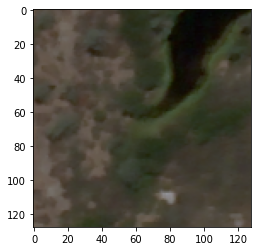

In [ ]:
# @title Inspect a patch to ensure data quality.
import numpy as np
import matplotlib.pyplot as plt

test = training_patches.first()

rgb = np.transpose(np.asarray(
    [test.getInfo()['properties']['R'],
     test.getInfo()['properties']['G'],
     test.getInfo()['properties']['B']]), [1,2,0])
figs, ax = plt.subplots()
ax.imshow(rgb.astype('uint8'))

## Train a model

If you have a lot of data, use Runtime > Change runtime type > GPU.

In [ ]:
# NOTE: These may vary from the paper implementation and should be tuned to your dataset.
LEARNING_RATE = 0.00005
DROPOUT = 0.4
BATCH_SIZE = 2
EPOCHS = 12
PATIENCE = 4

# Replace with the actual bucket into which the patches were exported.
train_file = 'gs://your-cloud-storage-bucket/demo_training_patches.tfrecord.gz'
val_file = 'gs://your-cloud-storage-bucket/demo_validation_patches.tfrecord.gz'

In [ ]:
from datetime import datetime

GLOBAL_MODEL_NUM = str(datetime.now().strftime("%Y%m%d_%H%M"))
print(GLOBAL_MODEL_NUM)

20230127_2117


In [ ]:
import tensorflow as tf

BANDS = ['R', 'G', 'B', 'slope']
RESPONSE = 'beaver'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in BANDS
]

COLUMNS = COLUMNS + [tf.io.FixedLenFeature(shape=[1], dtype=tf.float32)]

FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [ ]:
#@title Dataset reading library functions
def parse_tfrecord(example_proto):
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  inputsList = [inputs.get(key) for key in BANDS]
  # inputsList = inputsList[:3]
  stacked = tf.stack(inputsList, axis=0)
  stacked = tf.transpose(stacked, [1, 2, 0])
  label = tf.cast(inputs.pop(RESPONSE), tf.float32)
  # The label needs to be made into a patch of size [1, 1, 1]
  label = tf.expand_dims(label, 0)
  label = tf.expand_dims(label, 0)
  return tf.cast(stacked, tf.float32), label


def getDataset(pattern):
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset


# For multiple files
def getDatasets(files_list):
  dataset = tf.data.TFRecordDataset(files_list, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

In [ ]:
train_dataset = getDataset(train_file)
TRAIN_SIZE=len(list(train_dataset))
print(TRAIN_SIZE)
train_dataset = train_dataset.shuffle(buffer_size=TRAIN_SIZE)

val_dataset = getDataset(val_file)
VAL_SIZE=len(list(val_dataset))
print(VAL_SIZE)
val_dataset = val_dataset.shuffle(buffer_size=VAL_SIZE)

62
8


In [ ]:
check_image, check_label = iter(train_dataset.take(1)).next()
print(check_image, check_label)

tf.Tensor(
[[[ 65.        66.        46.        57.38957 ]
  [ 84.        80.        65.       100.1418  ]
  [ 97.        89.        77.        99.777016]
  ...
  [ 60.        63.        52.        49.496773]
  [ 62.        65.        54.        39.71785 ]
  [ 65.        66.        58.        30.528078]]

 [[ 65.        65.        47.        59.55931 ]
  [ 83.        78.        63.       101.46221 ]
  [ 94.        87.        73.        98.28311 ]
  ...
  [ 59.        62.        51.        50.794567]
  [ 62.        65.        56.        41.320347]
  [ 65.        67.        59.        27.6725  ]]

 [[ 82.        76.        64.        59.954044]
  [ 93.        86.        76.        97.47961 ]
  [ 93.        87.        74.        94.189415]
  ...
  [ 58.        62.        51.        52.648396]
  [ 61.        63.        54.        46.70016 ]
  [ 65.        66.        58.        31.187605]]

 ...

 [[119.       104.        89.        64.33004 ]
  [109.        94.        82.        62.115883]

## Model


/usr/local/lib/python3.8/dist-packages/keras/applications/resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


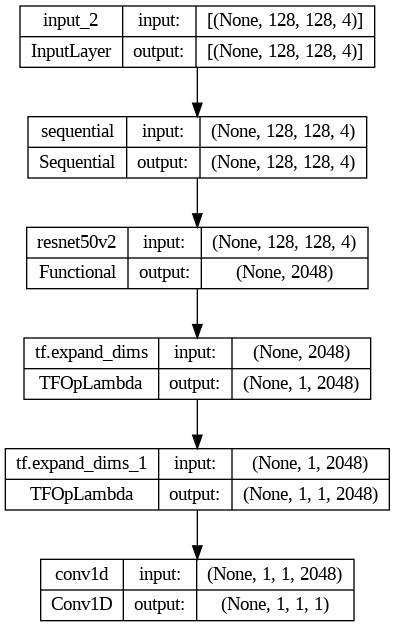

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.05, 0.05)),
])

image_size = tf.shape(check_image)
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(_KERNEL_SIZE, _KERNEL_SIZE, 4),
    pooling='max',
    classes=1,
    classifier_activation="sigmoid"
)
inputs = keras.Input(shape=np.array(image_size))
# Image augmentation block
x = base_model(data_augmentation(inputs))
x = tf.expand_dims(x, 1)
x = tf.expand_dims(x, 1)
x = layers.Conv1D(1, (1), activation="sigmoid")(x)
model = tf.keras.Model(inputs, x)

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=PATIENCE,
    restore_best_weights=True)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=[
             tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.RecallAtPrecision(precision=0.95, name='r@p=0.95'),
             tf.keras.metrics.PrecisionAtRecall(recall=0.95, name='p@r=0.95'),
             tf.keras.metrics.Recall(thresholds=0.5, name='recall@0.5'),
             tf.keras.metrics.Recall(thresholds=0.7, name='recall@0.7'),
             tf.keras.metrics.Recall(thresholds=0.9, name='recall@0.9'),
             tf.keras.metrics.Precision(thresholds=0.5, name='prec@0.5'),
             tf.keras.metrics.Precision(thresholds=0.7, name='prec@0.7'),
             tf.keras.metrics.Precision(thresholds=0.9, name='prec@0.9')
    ]
)

# Each epoch takes approx 1-2 mins
model.fit(
    train_dataset.batch(BATCH_SIZE),
    validation_data=val_dataset.batch(1),
    epochs=EPOCHS,
    callbacks=[early_stopping_callback, tensorboard_callback]
)


Epoch 1/12
31/31 [==============================] - 22s 136ms/step - loss: 0.5695 - binary_accuracy: 0.7097 - r@p=0.95: 0.0000e+00 - p@r=0.95: 0.2069 - recall@0.5: 0.2500 - recall@0.7: 0.0000e+00 - recall@0.9: 0.0000e+00 - prec@0.5: 0.2500 - prec@0.7: 0.0000e+00 - prec@0.9: 0.0000e+00 - val_loss: 0.6690 - val_binary_accuracy: 0.5000 - val_r@p=0.95: 0.0000e+00 - val_p@r=0.95: 0.2857 - val_recall@0.5: 0.0000e+00 - val_recall@0.7: 0.0000e+00 - val_recall@0.9: 0.0000e+00 - val_prec@0.5: 0.0000e+00 - val_prec@0.7: 0.0000e+00 - val_prec@0.9: 0.0000e+00
Epoch 2/12
31/31 [==============================] - 2s 56ms/step - loss: 0.5886 - binary_accuracy: 0.7903 - r@p=0.95: 0.0000e+00 - p@r=0.95: 0.2000 - recall@0.5: 0.0000e+00 - recall@0.7: 0.0000e+00 - recall@0.9: 0.0000e+00 - prec@0.5: 0.0000e+00 - prec@0.7: 0.0000e+00 - prec@0.9: 0.0000e+00 - val_loss: 0.6067 - val_binary_accuracy: 0.7500 - val_r@p=0.95: 0.0000e+00 - val_p@r=0.95: 0.2500 - val_recall@0.5: 0.0000e+00 - val_recall@0.7: 0.0000e+0

In [ ]:
model.evaluate(val_dataset.batch(1))

8/8 [==============================] - 0s 17ms/step - loss: 0.6067 - binary_accuracy: 0.7500 - r@p=0.95: 0.0000e+00 - p@r=0.95: 0.2500 - recall@0.5: 0.0000e+00 - recall@0.7: 0.0000e+00 - recall@0.9: 0.0000e+00 - prec@0.5: 0.0000e+00 - prec@0.7: 0.0000e+00 - prec@0.9: 0.0000e+00


[0.6066890954971313, 0.75, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

1/1 [==============================] - 0s 20ms/step


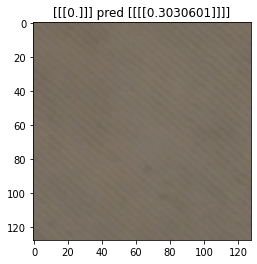

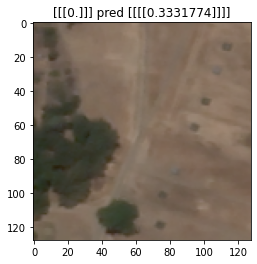

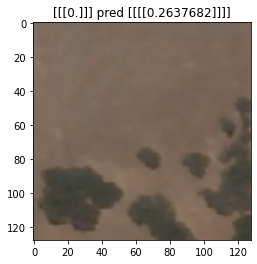

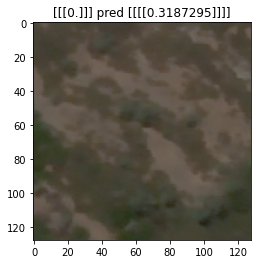

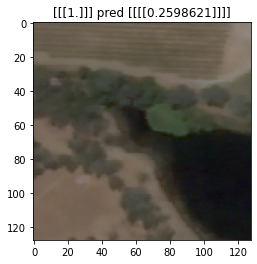

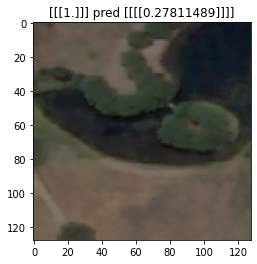

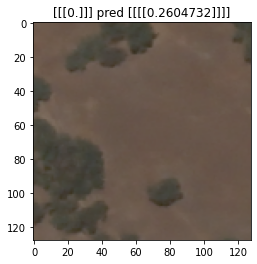

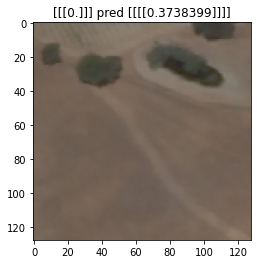

In [ ]:
import matplotlib.pyplot as plt

for image, label in val_dataset:
  pred = model.predict(tf.expand_dims(image, 0))
  image = image[:,:,:3]
  rgb = image.numpy()
  figs, ax = plt.subplots()
  ax.imshow(rgb.astype('uint8'))
  ax.set_title(np.array2string(label.numpy()) + ' pred ' + str(pred))

In [ ]:
model.save('gs://your-cloud-storage-bucket/demo_model', save_format='tf')

In [ ]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def('gs://your-cloud-storage-bucket/demo_model', 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "output"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_2:0": "array"}'
'{"StatefulPartitionedCall:0": "output"}'


In [ ]:
# Authenticate to the Earth Engine command line.
!earthengine authenticate --quiet

In [ ]:
# You need to set the project before using the model prepare command.
!earthengine set_project project-eager
!earthengine model prepare --source_dir 'gs://your-cloud-storage-bucket/demo_model' --dest_dir 'gs://your-cloud-storage-bucket/demo_model_eeified' --input {input_dict} --output {output_dict}

## Host the model



In [ ]:
MODEL_NAME = 'beaver_demo_model'
VERSION_NAME = 'v0'
REGION = 'us-central1'

!gcloud ai-platform models create {MODEL_NAME} \
  --project 'your-google-cloud-project' \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project 'your-google-cloud-project' \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.9 \
  --python-version=3.7

## Connect to the hosted model from Earth Engine and make predictions

In [ ]:
model = ee.Model.fromAiPlatformPredictor(
    projectName='your-google-cloud-project',
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    region=REGION,
    inputTileSize=[64, 64],
    inputOverlapSize=[32, 32],
    proj=ee.Projection('EPSG:4326').atScale(1),
    fixInputProj=True,
    inputShapes={'array': [4]},
    outputTileSize=[1, 1],
    outputBands={'output': {
          'type': ee.PixelType.float(),
          'dimensions': 1
      }
    },
)

array = _get_image(
    presence_points.geometry().bounds(10), ee.Date('2014-07-03')).toArray()

predictions = model.predictImage(array).arrayGet([0]).selfMask()
output_scale = predictions.projection().nominalScale()
print('outputScale', output_scale.getInfo())

outputScale 63.99999999999999


In [ ]:
import folium

# Optional: mask the predictions by threshold.
# predictions = predictions.mosaic().gt(0.8).selfMask()

# Get map IDs for display in folium.
probability_vis = {'max': 0.5, 'palette': 'red'}
probability_mapid = predictions.getMapId(probability_vis)

# Visualize the input imagery and the predictions.
map = folium.Map(location=[38.607, -122.48], zoom_start=13)

folium.TileLayer(
  tiles=probability_mapid['tile_fetcher'].url_format,
  attr='Map Data © Google Earth Engine',
  overlay=True,
  name='probability',
).add_to(map)
map.add_child(folium.LayerControl())
map
